In [57]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os
import sys
import glob

In [2]:
# initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')
initial_values = Table.read('../catalogs/galah_dr4_allspec_230206.fits')

In [3]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [4]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [5]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [6]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [7]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [8]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [9]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -1.00:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [10]:
def test_progress(print_train_only=False):
    
    number_points_calculated_all = []
    number_points_needed_all = []
    
    for test_grid_index in grids['index_subgrid']:#[grids_converted_to_nn_input]:

        # Find upper and lower Teff points
        test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
        if test_grid_teff <= 4000:
            test_grid_teff_lower = test_grid_teff - 100
        else:
            test_grid_teff_lower = test_grid_teff - 250
        if test_grid_teff <= 3900:
            test_grid_teff_higher = test_grid_teff + 100
        else:
            test_grid_teff_higher = test_grid_teff + 250

        # Find upper and lower logg points
        test_grid_logg = grids['logg_subgrid'][test_grid_index]
        test_grid_logg_lower = test_grid_logg - 0.5
        test_grid_logg_higher = test_grid_logg + 0.5

        # Find upper and lower fe_h points
        test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
        if test_grid_fe_h <= -1.00:
            test_grid_fe_h_lower = test_grid_fe_h - 0.5
        else:
            test_grid_fe_h_lower = test_grid_fe_h - 0.25
        if test_grid_fe_h <= -1.5:
            test_grid_fe_h_higher = test_grid_fe_h + 0.5
        else:
            test_grid_fe_h_higher = test_grid_fe_h + 0.25

        number_points_calculated_each = 0
        number_points_needed_each = 0
        next_needed = None
        
        for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
            for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
                for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                    
                    t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                    
                    if len(t) > 0:
                        number_points_needed_each += 1
                        if t[0] in grids_converted_to_nn_input:
                            number_points_calculated_each += 1
                        else:
                            next_needed = t[0]
                    else:
                        # there is no grid point for this one.
                        pass

        number_points_calculated_all.append(number_points_calculated_each)
        number_points_needed_all.append(number_points_needed_each)
        
        try:
            counts = priority['counts_dr4_init'][priority['index_subgrid']==test_grid_index][0]
            if counts < 10:
                counts = str(counts)+'    '
            elif counts < 100:
                counts = str(counts)+'   '
            elif counts < 1000:
                counts = str(counts)+'  '
            elif counts < 10000:
                counts = str(counts)+' '
            else:
                counts = str(counts)
        except:
            counts = 'none '
            
        space = ''
        if test_grid_fe_h >= 0:
            space = ' '

        if number_points_calculated_each == number_points_needed_each:
            if test_grid_index in trained_3x3x3:
                pass
                # print(str(test_grid_index)+' trained 3x3x3')
            else:
                print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' -----------------------------------------------------      TRAIN!!!')
        elif number_points_calculated_each > number_points_needed_each - 7:
            if next_needed in grids_done:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                             CONVERT')
            elif next_needed in grids_started:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, '                PBS running')
            else:
                if not print_train_only:
                    print(str(test_grid_index)+' '+str(int(test_grid_teff))+'_'+"{:.2f}".format(test_grid_logg)+'_'+"{:.2f}".format(test_grid_fe_h)+space+' '+counts+' only '+str(number_points_needed_each - number_points_calculated_each)+' more:', next_needed, ' Submit to PBS!')

In [58]:
grids_started = [
#     609,
#     618,
#     619,
#     630,
#     631,
    2419,
    2431,
    2467,
    2479,
    2491,
]
print(len(grids_started))

5


In [59]:
grids_done = [
    96,97,98,
    107,108,109,
    213,214,215,
    225,226,227,
    234,235,236,
    244,245,246,
    339,340,341,
    351,352,353,
    359,
    360,361,362,
    369,
    370,371,372,
    380,381,382,
    440,441,442,
    452,453,454,
    464,
    465,466,467,
    477,478,479, # for analysis of 131216001101084
    485,486,487,488,
    495,496,497,498,
    507,508,509,
    519,520,521,
    567,568,569,
    570,
    579,
    580,581,582,
    591,592,593,594,
    604,605,606,
    610,611,612,
    620,621,622,
    632,633,634,
    644,645,646,
    692,693,694,695,
    704,705,706,707,
    716,717,718,719,
    729,
    730,731,
    734,735,736,
    741,742,743,744,745,746,   
    753,754,755,756,757,758,
    765,766,767,768,769,
    770,
    816,817,818,819,
    828,829,
    830,831,
    839,
    840,841,842,
    851,852,853,
    856,857,858,
    862,863,864,865,
    866,867,868,
    873,874,875,
    876,877,878,879,
    880,
    887,888,889,
    890,891,892,
    902,903,904,
    951,952,953,
    963,964,965,
    975,976,977,
    980,981,982,
    986,987,988,989,
    990,991,992,
    996,997,998,999,
    1000,1001,1002,1003,1004,
    1008,1009,
    1010,1011,1012,1013,1014,1015,1016,
    1023,1024,1025,1026,1027,1028,
    1074,1075,1076,1077,1078,1079,
    1086,1087,1088,1089,
    1090,1091,
    1097,1098,1099,
    1100,1101,1102,1103,1104,
    1109,1110,1111,1112,1113,1114,1115,
    1119,
    1120,1121,1122,1123,1124,1125,1126,1127,
    1131,1132,1133,1134,1135,1136,1137,1138,1139,
    1140,
    1143,1144,1145,1146,1147,1148,1149,
    1150,1151,1152,
    1155,1156,1157,
    1159,
    1160,1161,1162,1163,1164,
    1167,1168,
    1184,1185,1186,1187,1188,
    1196,1197,1198,1199,
    1200,1201,1202,
    1208,1209,
    1210,1211,1212,1213,1214,
    1219,
    1220,1221,1222,1223,1224,1225,1226,
    1128,
    1231,1232,1233,1234,1235,1236,1237,
    1241,1242,1243,1244,1245,1246,1247,1248,1249,
    1250,
    1253,1254,1255,1256,1257,1258,1259,
    1260,1261,1262,1263,
    1265,1266,1267,1268,1269,
    1270,1271,1272,1273,1274,1275,
    1277,1278,1279,
    1280,1281,1282,1283,1284,1285,1286,1287,
    1289,
    1290,1291,1293,1294,1295,1296,1297,1298,1299,
    1306,1307,1308,1309,
    1310,1311,
    1318,1319,
    1320,1321,1322,1323,
    1324,
    1330,1331,1332,1333,1334,1335,1336,
    1340,1341,1342,1343,1344,1345,1346,
    1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,
    1362,1363,1364,1365,1366,1367,1368,1369,
    1370,1371,1372,
    1374,1375,1376,1377,1378,1379,
    1380,1381,1382,1383,1384,
    1386,1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,
    1398,1399,
    1400,1401,1402,1403,1404,1405,1406,1407,1408,
    1414,1415,1416,1417,1418,1419,
    1420,
    1426,1427,1428,1429,
    1430,1431,1432,1433,
    1438,1439,
    1440,1441,1442,1443,1444,1445,
    1446,1447,1448,1449,
    1450,
    1456,1457,1458,1459,
    1460,1461,1462,1463,1464,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,1477,1478,
    1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1490,
    1492,1493,1494,1495,1496,1497,1498,1499,
    1500,1501,1502,
    1504,1505,1506,1507,1508,1509,
    1510,1511,1512,1513,1514,
    1518,1519,
    1520,1521,1522,1523,1524,1525,1526,
    1532,1533,1534,1535,1536,1537,1538,1539,
    1544,1545,1546,1547,1548,1549,
    1550,1551,1552,1553,1554,
    1559,
    1560,1561,1562,1563,1564,1565,
    1571,1572,1573,1574,1575,1576,1577,1578,1579,
    1580,
    1583,1584,1585,1586,1587,1588,1589,
    1590,1591,1592,1593,
    1595,1596,1597,1598,1599,
    1600,1601,1602,1603,1604,1605,
    1607,1608,1609,
    1610,1611,1612,1613,1614,1615,1616,1617,
    1620,1621,1622,1623,1624,
    1625,1626,1627,1628,1629,
    1635,1636,1637,1638,1639,
    1640,1641,1642,
    1647,1648,1649,
    1650,1651,1652,1653,1654,
    1658,1659,
    1660,1661,1662,1663,
    1670,1671,1672,1673,1674,1675,1676,1677,1678,
    1682,1683,1684,1685,1686,1687,1688,1689,
    1690,1691,1692,
    1694,1695,1696,1697,1698,1699,
    1700,1701,1702,1703,1704,
    1707,1708,1709,
    1710,1711,1712,
    1713,1714,1715,1716,
    1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,
    1733,1734,1735,1736,1737,1738,1739,
    1740,1741,
    1746,1747,1748,1749,
    1750,1751,1752,1753,1754,1755,
    1765,1766,1767,1768,1769,
    1770,1771,
    1777,1778,1779,
    1780,1781,1782,1783,1784,1785,1786,
    1789,
    1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,
    1802,1803,1804,1805,1806,1807,1808,1809,
    1810,1811,
    1814,1815,1816,1817,1818,1819,
    1820,1821,1822,1823,1824,
    1827,1828,1829,
    1830,1831,1832,1833,1834,1835,1836,
    1840,1841,1842,1843,1844,1845,1846,1847,1848,
    1851,1852,1853,1864,1865,
    1863,
    1875,1876,1877,1878,1879,
    1880,1881,1882,1883,1884,
    1888,1889,
    1890,1891,
    1892,1893,1894,1895,1896,1897,
    1900,1901,1902,1903,
    1904,1905,1906,1907,1908,1909,
    1910,
    1913,1914,1915,1916,1917,1918,1919,
    1920,1921,1922,
    1925,1926,1927,1928,1929,
    1930,1931,1932,1933,1934,
    1972,1973,1974,1975,1976,1977,1978,1979,
    1980,
    1984,1985,1986,1987,1988,1989,
    1990,1991,1992,1993,
    1996,1997,1998,1999,
    2000,2001,2002,2003,2004,2005,
    2008,2009,
    2010,2011,2012,2013,2014,2015,2016,2017,
    2049,
    2050,2051,2052,2053,2054,2055,2056,2057,
    2061,2062,2063,2064,2065,2066,2067,2068,2069,
    2070,
    2073,2074,2075,2076,2077,2078,2079,
    2080,2081,2082,
    2085,2086,2087,2088,2089,
    2090,2091,2092,2093,2094,
    2123,2124,2125,2126,2127,2128,2129,
    2130,
    2135,2136,2137,2138,2139,
    2140,2141,2142,2143,
    2147,2148,2149,
    2150,2151,2152,2153,2154,2155,
    2159,
    2160,2161,2162,2163,2164,2165,2166,2167,
    2197,2198,2199,
    2200,2201,2202,
    2209,
    2210,2211,2212,2213,2214,2215,
    2221,2222,2223,2224,2225,2226,2227,
    2233,2234,2235,2236,2237,2238,2239,
    2270,2271,2272,
    2285,
    2297,
    2305,2306,2307,
    2309,
    2346,2347,2348,
    2350,
    2358,2359,
    2360,
    2362,
    2370,2371,2372,
    2374,
    2281,2282,2283,2284,
    2293,2294,2295,2296,
    2308,
    2335,2336,2337,
    2349,
    2361,
    2373,
    2385,2386,2387,
    2397,2398,2399,
    2400,2401,
    2407,2408,2409,
    2410,2411,2412,2413,
    2420,2421,2422,2423,2424,2425,
    2432,2433,2434,2435,2436,2437,
    2444,2445,2446,
    2456,2457,2458,2459,
    2460,
    2468,2469,
    2470,2471,2472,2473,
    2480,2481,2482,2483,2484,2485,
    2492,2493,2494,2495,2496,2497,
]
print(len(grids_done),len(grids_done) * 280)

1062 297360


In [60]:
# # selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
# # selection = (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200) & (priority['teff_subgrid'] <= 6000)
# # selection = (priority['fe_h_subgrid'] <= -0.75) & (priority['counts_dr4_init'] > 2800)
# # selection = (priority['teff_subgrid'] == 7250) & (priority['counts_dr4_init'] > 200)
# # selection = (priority['counts_dr4_init'] <= 2500) & (priority['counts_dr4_init'] > 2000)
# # selection = (priority['counts_dr4_init'] <= 2000) & (priority['counts_dr4_init'] > 1000)
# selection = (priority['counts_dr4_init'] <= 1000) & (priority['counts_dr4_init'] > 500)
# # selection = (priority['teff_subgrid'] <= 3999) &(priority['logg_subgrid'] >= 4.0) & (priority['counts_dr4_init'] > 290)
# # selection = (priority['logg_subgrid'] <= 3.5) &(priority['logg_subgrid'] >= 2.5) & (priority['counts_dr4_init'] > 2000)
# # selection = (priority['teff_subgrid'] <= 3500) & (priority['counts_dr4_init'] > 200)

# f, gs = plt.subplots(1,2,figsize=(10,5))
# ax=gs[0]
# s = ax.scatter(
#     priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
#     priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
#     c = priority['counts_dr4_init'][selection],
# )
# plt.colorbar(s, ax=ax)
# ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(ax.get_ylim()[::-1])
# ax=gs[1]
# s = ax.scatter(
#     priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
#     priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
#     c = priority['fe_h_subgrid'][selection],vmin=-2,vmax=0.75
# )
# plt.colorbar(s, ax=ax)
# ax.set_xlim(ax.get_xlim()[::-1])
# ax.set_ylim(ax.get_ylim()[::-1])
# plt.tight_layout()
# plt.show()
# plt.close()

# print(list(priority['index_subgrid'][selection]))

# priority[selection]

In [61]:
# 4000_1.00_-3.00

# 4250_1.50_-2.00
# 4250_2.00_-2.50
# 4250_2.50_-3.00
# 4250_1.00_-3.00

# 4500_2.50_-2.50

# 4750_2.50_-3.00
# 5000_2.00_-2.50
# 5250_1.50_-2.50
# 5500_2.00_-2.50
grids['model_name'][1277]

'4250_2.50_-3.00'

In [62]:
# ALREADY DONE
selection = [
    1588,1487,1589,1441,1319,1320,
    2002, 1499, 2001, 1919, 2078, 2079, 1918, 1394, 1500, 1931, 1920, 1845,
    1930, 2151, 1498, 2482, 1833, 2014, 1844, 1750,
    2003, 2000, 1381, 1512, 1917, 2013, 1932, 2359, 2224, 1627, 1832, 1749,
    1651, 1393, 1601, 1834, 1846, 1259, 2077, 2294, 1511,
    1626, 2152, 1380, 1614, 1615,
    1260, 1748, 1650, 1548, 1929, 1602, 1272, 2422, 1843, 1649,
    1831, 2015, 1613, 1382, 2091, 1725, 2470, 2066, 1990, 2080, 1726, 2012, 2090, 1138, 1603, 1625,
    1989, 1751, 1442, 1907, 1547, 1258, 1738, 1510, 1271, 1652, 1628, 1392, 1524,
    1921, 1906, 1546, 1443, 1821, 2067, 1395, 879, 
    1444, 
    1125,
    1916, 
    1549, 1600, 1379, 2150, 1737, 1739, 1513,
    1499, 1394, 1500, 1498, 1512, 1627, 1393, 1601, 1511, 1626, 1614, 1615, 1602, 1613, 1725, 2470, 2066, 1990, 1726, 1603, 1625, 1989, 1907, 1510, 1628, 1392, 1524, 1906, 1821, 2067, 1395, 1600, 1513,
    964,
    1211,
    1259,
    1333,
    1442,
    1997, # 6000_4.00_-1.50
    1915, # 5750_4.00_-1.00
    1916, # 5750_4.00_-0.75
    1998, # 6000_4.00_-1.00
    1999, # 6000_4.00_-0.75
    1698, # 5250_2.50_-1.00
    1496, # 4750_2.50_-1.00
    1257, # 4250_1.50_-1.00
    1485,
    1486,
    1985,
    621,
#     6000_4.00_-1.50
#     5750_4.00_-1.00
#     6000_4.00_-1.00
#     5250_2.50_-1.00
#     4750_2.50_-1.00
#     4250_1.50_-1.00
#     1913,1914,
    1915,1916,1917,
    # 5750_4.00_-2.00..-0.50
#     1925,1926,
    1927,1928,1929,
    # 5750_4.50_-2.00..-0.50
#     1996,1997,
    1998,1999,2000,
    # 6000_4.00_-2.00..-0.50
#     2008,2009,
    2010,2011,2012,
    # 6000_4.50_-2.00..-0.50
#     2073,2074,
    2075,2076,2077,
#     # 6250_4.00_-2.00..-0.50
#     1815,1816,1817,1818,1819,
#     # 5500_3.50_-2.00..-0.50
#     1827,1828,1829,1830,1831,
#     # 5500_4.00_-2.00..-0.50
#     1839,1840,1841,1842,1843,
#     # 5500_4.50_-2.00..-0.50
#     1901,1902,1903,1904,1905,
#     # 5750_3.50_-2.00..-0.50
#     1984,1985,1986,1987,1988,
#     # 6000_3.50_-2.00..-0.50
#     2061,2062,2063,2064,2065,
#     # 6250_3.50_-2.00..-0.50
#     2085,2086,2087,2088,2089,
#     # 6250_4.50_-2.00..-0.50
#     2134,2135,2136,2137,2138,
#     # 6500_3.50_-2.00..-0.50
#     2146,2147,2148,2149,2150,
#     # 6500_4.00_-2.00..-0.50
#     2158,2159,2160,2161,2162,
#     # 6500_4.50_-2.00..-0.50
    1747,1842,2076,2088,2137,
    496,361,605,226,
    1497, 1820, 1003, 1487, 1126, 1137, 1525, 1616, 1273, 2225, 1334, 2139, 1486, 1724, 2065, 1501, 1333, 1714, 757, 1988, 1999, 1908, 1933, 1835, 1441, 1713, 1736, 1523, 1727, 1822, 1440, 1366, 621, 1905, 1124, 1612, 2295, 1484, 1991, 2004, 2076,
    1111,1225,1495,1573,1574,1687,1699,
    1246,1806,2481,1509,
    1247,1246,2481,2493,1332,1589,1500,1441,1112,1336,986,1683,1575,987,1488,
    1002,1321,1406,1407,1488,1575,1683,1624,1248,1113,
    986,987,988,989,
    1246, 1247, 2481, 1488, 1112, 1383, 1487, 1589, 1486,
    1225, 1588, 1248, 2493, 1111, 1261, 2469, 2212, 1113, 1546,
    1332, 1441, 1429, 2457, 1321, 1406, 1636, 1319, 1320, 1686,
    1368, 1847, 2153, 1485, 745, 1639, 2140, 1367, 1488, 1928, 2212, 1809, 1604, 1211, 1830, 1640, 1015, 1819, 1002, 496, 1406, 2089, 1715, 2092, 2138, 2282, 1599, 964, 1712, 2360, 1842, 1483, 1332, 1550, 2347, 1245, 2163, 2296, 1624, 1702, 867, 2213, 1637, 2149, 1638, 1808, 633, 1365, 2068, 1699, 2226, 1915,
    864,
    865,
    876,
    877,
    745,
    580,
    705,
    706,
#     # First star for Gary
    1119,
    1241,
    1255,1266,
    1221,
    1492,1584,1671,1778,1387,
    1277,1533,1210,
    743,
    1610,2480,
#     2223,
#     2054,
#     1546,
#     2480,
#     2293,
#     2223,
#     2358,
#     1139,
#     1509,
#     2421,
#     1274,
#     1210,
#     1285,
#     2281,
#     1286,
#     744,
#     2468
]

# selection = []

for t in selection:
    test_grid_index_computations(t)

609,
618,
619,
630,
631,


In [77]:
grids_converted_to_nn_input = [
    96,97,98,
    107,108,109,
    213,214,215,
    225,226,227,
    234,235,236,
    244,245,246,
    339,340,341,
    351,352,353,
    359,
    360,361,362,
    369,
    370,371,372,
    380,381,382,
    440,441,442,
    452,453,454,
    464,465,466,467,
    477,478,479,
    485,486,487,488,
    495,496,497,498,
    507,508,509,
    519,
    520,521,
    567,568,569,
    570,
    579,
    580,581,582,
    591,592,593,594,
    604,605,606,
    610,611,612,
    620,621,622,
    632,633,634,
    644,645,646,
    692,693,694,695,
    704,705,706,707,
    716,717,718,719,
    729,
    730,731,
    734,735,736,
    741,742,743,
    744,745,746,
    753,754,755,756,757,758,
    765,766,767,768,769,
    770,
    816,817,818,819,
    828,829,
    830,831,
    839,
    840,841,842,
    851,852,853,
    856,857,858,
    862,863,864,865,
    866,867,868,
    873,874,875,876,877,
    878,879,
    880,
    887,888,889,
    890,891,892,
    902,903,904,
    951,952,953,
    963,964,965,
    975,976,977,
    980,981,982,
    986,987,988,989,
    990,991,992,
    996,997,998,999,
    1000,1001,1002,1003,1004,
    1008,1009,
    1010,
    1011,1012,1013,1014,1015,1016,
    1023,1024,1025,1026,1027,1028,
    1074,1075,1076,1077,1078,1079,
    1086,1087,1088,1089,
    1090,1091,
    1097,1098,1099,
    1100,1101,1102,1103,1104,
    1109,1110,1111,1112,1113,1114,1115,
    1119,
    1120,1121,1122,1123,1124,1125,1126,1127,1128,
    1131,1132,1133,1134,1135,1136,1137,1138,1139,
    1140,
    1143,1144,1145,1146,1147,1148,1149,
    1150,1151,1152,
    1155,1156,1157,
    1159,
    1160,1161,1162,1163,1164,
    1167,1168,
    1184,1185,1186,1187,1188,
    1196,1197,1198,1199,
    1200,1201,1202,
    1208,1209,
    1210,1211,1212,1213,1214,
    1219,1220,1221,1222,1223,1224,1225,1226,
    1231,1232,1233,1234,1235,1236,1237,
    1241,1242,1243,1244,1245,1246,1247,1248,1249,
    1250,
    1253,1254,1255,1256,
    1257,1258,1259,
    1260,1261,1262,1263,
    1265,1266,1267,1268,1269,
    1270,1271,
    1272,1273,1274,1275,
    1277,1278,1279,
    1280,1281,1282,1283,1284,1285,1286,1287,
    1289,
    1290,1291,
    1293,1294,1295,1296,1297,1298,1299,
    1306,1307,1308,1309,
    1310,1311,
    1318,1319,
    1320,1321,1322,1323,1324,
    1330,1331,1332,1333,1334,1335,1336,
    1340,1341,1342,1343,1344,1345,1346,
    1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,
    1362,1363,1364,1365,1366,1367,1368,1369,
    1370,1371,1372,
    1374,1375,1376,1377,1378,1379,
    1380,1381,1382,1383,1384,
    1386,1387,1388,1389,
    1390,1391,1392,1393,1394,1395,1396,
    1398,1399,
    1400,1401,1402,1403,1404,1405,1406,1407,1408,
    1414,1415,1416,1417,1418,1419,
    1420,
    1426,1427,1428,1429,
    1430,1431,1432,1433,
    1438,1439,
    1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,
    1450,
    1456,1457,1458,1459,
    1460,1461,1462,1463,1464,
    1468,1469,
    1470,1471,1472,1473,1474,1475,1476,1477,1478,
    1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,
    1490,
    1492,1493,1494,1495,1496,
    1497,1498,1499,
    1500,1501,1502,
    1504,1505,1506,1507,1508,1509,
    1510,1511,1512,1513,1514,
    1518,1519,
    1520,1521,1522,1523,1524,1525,1526,
    1532,1533,1534,1535,1536,1537,1538,1539,
    1544,1545,1546,1547,1548,1549,
    1550,1551,1552,1553,1554,1559,
    1659,
    1560,1561,1562,1563,1564,1565,
    1571,1572,1573,1574,1575,1576,1577,1578,1579,
    1580,
    1583,1584,1585,1586,1587,1588,1589,
    1590,1591,1592,1593,
    1595,1596,1597,1598,1599,
    1600,1601,1602,1603,1604,1605,
    1607,1608,1609,
    1610,1611,1612,1613,1614,1615,1616,1617,
    1620,1621,1622,1623,
    1624,1625,1626,1627,1628,1629,
    1635,1636,1637,1638,1639,
    1640,1641,1642,
    1647,1648,1649,
    1650,1651,1652,1653,1654,
    1658,
    1660,1661,1662,1663,
    1670,
    1678,
    1682,
    1690,
    1694,1695,1696,1697,
    1671,1672,1673,1674,1675,1676,1677,
    1683,1684,1685,1686,1687,1688,1689,
    1691,1692,
    1698,1699,
    1700,1701,1702,1703,1704,
    1707,1708,1709,
    1710,1711,1712,1713,1714,1715,1716,
    1719,
    1720,1721,1722,1723,
    1724,1725,1726,1727,1728,1729,
    1733,1734,1735,1736,1737,1738,1739,
    1740,1741,
    1746,1747,1748,1749,
    1750,1751,1752,1753,1754,1755,
    1765,1766,1767,1768,1769,
    1770,1771,
    1777,1778,1779,
    1780,1781,1782,1783,1784,1785,1786,
    1789,
    1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,
    1802,1803,1804,1805,1806,1807,1808,1809,
    1810,1811,
    1814,1815,1816,1817,
    1818,1819,
    1820,1821,1822,1823,1824,
    1827,1828,1829,
    1830,1831,1832,1833,1834,1835,1836,
    1840,1841,1842,1843,1844,1845,1846,1847,1848,
    1851,1852,1853,
    1863,1864,1865,
    1875,1876,1877,1878,1879,
    1880,1881,1882,1883,1884,
    1888,1889,
    1890,1891,1892,
    1893,1894,1895,1896,1897,
    1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,
    1910,
    1913,1914,1915,1916,1917,1918,1919,
    1920,1921,1922,
    1925,1926,1927,1928,1929,
    1930,1931,1932,1933,1934,
    1972,1973,1974,1975,1976,1977,1978,1979,
    1980,
    1984,1985,1986,1987,1988,1989,
    1990,1991,1992,1993,
    1996,1997,1998,1999,
    2000,2001,2002,2003,2004,2005,
    2008,2009,
    2010,2011,2012,2013,2014,2015,2016,2017,
    2049,
    2050,2051,2052,2053,2054,2055,2056,2057,
    2061,2062,2063,2064,2065,2066,2067,2068,2069,
    2070,
    2073,2074,2075,2076,2077,2078,2079,
    2080,2081,2082,
    2085,2086,2087,2088,2089,
    2090,2091,2092,2093,2094,
    2123,2124,2125,2126,2127,2128,2129,
    2130,
    2135,2136,2137,2138,2139,
    2140,2141,2142,2143,2214,
    2147,2148,2149,
    2150,2151,2152,2153,2154,2155,
    2159,
    2160,2161,2162,2163,2164,2165,2166,2167,
    2197,2198,2199,
    2200,2201,2202,
    2209,
    2210,2211,2212,2213,
    2215,
    2221,2222,2223,2224,2225,2226,2227,
    2233,2234,2235,2236,2237,2238,2239,
    2270,2271,2272,
    2281,2282,2283,2284,2285,
    2293,2294,2295,2296,2297,
    2305,2306,2307,2308,2309,
    2335,2336,2337,
    2346,2347,2348,2349,
    2350,
    2358,2359,
    2360,2361,2362,
    2370,2371,2372,2373,2374,
    2385,2386,2387,
    2397,2398,2399,
    2400,2401,
    2408,2409,
    2410,2411,2412,
    2413,
    2420,2421,2422,2423,2424,2425,
    2432,2433,2434,2435,2436,2437,
    2444,2445,2446,
    2456,2457,2458,2459,
    2460,
    2468,2469,
    2470,2471,2472,2473,
    2480,2481,2482,2483,2484,2485,
    2492,2493,2494,2495,2496,2497,
]
print(len(grids_converted_to_nn_input))

1061


In [78]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")
print("os.system('ipython galah_dr4_grid_interpolation_recommend_labels.py '+str(p))")

2407,
1
import os
ps = [2407]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))
os.system('ipython galah_dr4_grid_interpolation_recommend_labels.py '+str(p))


In [79]:
# Currently converting
# t1: 2407
# t2: 
# t3: 
# t4: 

In [80]:
trained_3x3x3 = [
    108,
    226,
    352,
    361,
    478,
    486,
    496,
    580,
    605,
    611,
    621,
    633,
    705,
    706,
    718,
    730,
    735,
    745,
    757,
    841,
    852,
    856,857,
    864,865,866,867,
    876,877,878,879,
    964,
    976,
    980,
    986,987,988,989,
    990,
    1000,1001,1002,1003,
    1015,
    1088,
    1099,
    1103,
    1109,1110,1111,1112,1113,
    1119,
    1120,1121,1122,1123,1124,1125,1126,
    1135,1136,1137,1138,
    1210,1211,1212,1213,1214,
    1221,1222,1223,1224,1225,
    1231,
    1232, # Training with 6415 spectra (89%), Testing with 713 spectra (10%), 9033.599 validation loss = 8952.251
    1233, # Training with 6679 spectra (89%), Testing with 743 spectra (10%), 8569.789 validation loss = 8407.385
    1234,
    1241,1242,1243,
    1244, # Training with 11232 spectra (90%), Testing with 1248 spectra (10%), 8918.089 validation loss = 8923.438
    1245,1246,1247,1248,
    1253,1254,1255,1256,1257,1258,1259,
    1260,1261,
    1265,1266,
    1270,1271,1272,1273,
    1277,
    1319,
    1320,1321,
    1331,1332,1333,1334,1335,1336,
    1340,
    1341,1342,1343,
    1350,1351,1352,1353,1354,1355,
    1362,1363,1364, # Training with 9423 spectra (90%), Testing with 1047 spectra (10%), 9559.972 validation loss = 9560.110, 22.216 validation loss = 23.934
    1365, # Training with 10330 spectra (89%), Testing with 1148 spectra (10%), 9244.988 validation loss = 9285.615
    1366, # Training with 9536 spectra (89%), Testing with 1060 spectra (10%), 8949.833 validation loss = 8970.894
    1367,1368,1369,
    1374,1375,1376,1377,1378,
    1379,
    1380,1381,1382,
    1383,
    1386,1387,
    1391,1392,1393,1394,1395,
    1404,1405,1406,1407,
    1416,1417,1418,1419,
    1428,1429,
    1430,1431,
    1440,1441,1442,1443,1444,1445,1446, # Training with 4035 spectra (89%), Testing with 449 spectra (10%), 9751.414 validation loss = 9754.023, 24.017 validation loss = 25.208
    1447, # Training with 5239 spectra (89%), Testing with 583 spectra (10%), 9573.558 validation loss = 9554.650
    1448,
    1456,1457,1458, # Training with 8748 spectra (89%), Testing with 973 spectra (10%), 9678.605 validation loss = 9680.667, 19.176 validation loss = 18.841
    1459, # Training with 10179 spectra (89%), Testing with 1132 spectra (10%), 9354.261 validation loss = 9443.805
    1460,
    1468,1469,
    1470, # Training with 9915 spectra (89%), Testing with 1102 spectra (10%), 9699.579 validation loss = 9660.728
    1471, # Training with 10410 spectra (89%), Testing with 1157 spectra (10%), 9457.726 validation loss = 9459.764
    1472,1473,
    1480,1481,1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    1483, # Training with 10544 spectra (89%), Testing with 1172 spectra (10%), 9465.517 validation loss = 9439.481, 25.909 validation loss = 26.766
    1484,1485,1486,1487,1488,
    1492,1493,1494,1495,1496,1497,1498,1499,
    1500,1501,
    1509,
    1510,1511,1512,1513,
    1521,1522,1523,1524,1525,
    1533,1534,1535,1536,1537,
    1545,1546,1547,1548,1549,
    1550,1551,1552,
    1559,
    1560,1561,1562,
    1571,1572,1573,1574,1575,
    1583,1584,1585,
    1586, # Training with 11475 spectra (90%), Testing with 1275 spectra (10%), 9513.832 validation loss = 9504.287
    1587,1588,1589,
    1590,
    1597,1598,1599,
    1600,1601,1602,1603,1604,
    1611,1612,1613,1614,1615,1616,
    1624,1625,1626,1627,1628,
    1636,1637,1638,1639,
    1640,
    1648,1649,
    1650,1651,1652,1653,1654,
    1658,1659,
    1670,1671,
    1682,1683,1684,1685,1686,1687,
    1696,1697,1698,1699,
    1700,1701,1702,
    1708, # Training with 11333 spectra (89%), Testing with 1260 spectra (10%), 
    1709,
    1710,1711,1712,1713,1714,1715,
    1723,1724,1725,1726,1727,
    1735,1736,1737,1738,1739,
    1747,1748,1749, # Training with 8410 spectra (89%), Testing with 935 spectra (10%), 9122.635 validation loss = 9003.748, 40.247 validation loss = 43.474
    1750,1751,1752,1753,1754,1755,
    1765,1766,
    1777,1778,
    1803,1804,1805,1806,1807,1808,1809,
    1817,1818,1819,
    1820,1821,1822,
    1830,1831,1832,1833,1834,1835,1836,
    1842,1843,1844,1845,1846,1847,1848,
    1902,1903,1904,1905,1906,1907,1908,
    1915,1916,1917,1918,1919,
    1920, # Training with 10884 spectra (89%), Testing with 1210 spectra (10%), 8908.265 validation loss = 8927.847
    1921,1922,
    1927,1928,1929,
    1930, # Training with 8631 spectra (90%), Testing with 959 spectra (10%), 9365.203 validation loss = 9314.398
    1931,
    1932, # Training with 8355 spectra (89%), Testing with 929 spectra (10%), 8988.107 validation loss = 8910.192, 35.799 validation loss = 39.891
    1933,1934,
    1985,1986,1987,1988,1989,
    1990,1991,
    1997,1998,1999,
    2000,
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
    2004,2005, 
    2009,
    2010,2011,
    2012,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
    2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
    2015, # Training with 9162 spectra (90%), Testing with 1018 spectra (10%), 9057.569 validation loss = 9055.459,
    2016, # Training with 9016 spectra (89%), Testing with 1002 spectra (10%), 8809.333 validation loss = 8878.590
    2017,
    2063,2064,2065,2066,2067,2068,
    2075,2076,2077,2078,2079,
    2080,2081,2082,
    2087,2088,2089,
    2090, # Training with 9532 spectra (89%), Testing with 1060 spectra (10%), 9431.687 validation loss = 9428.241, 18.959 validation loss = 19.571
    2091, # Training with 9648 spectra (90%), Testing with 1072 spectra (10%), 9301.318 validation loss = 9283.762, 23.940 validation loss = 24.879
    2092,
    2093,
    2094,
    2137,2138,2139,
    2140,
    2149,
    2150,2151,2152,2153,
    2161,2162,2163,2164,2165,
    2212,2213,
    2224,2225,2226,
    2236,2237,2238,
    2282,
    2294,2295,2296,
    2306,2307,2308,
    2347,
    2359,
    2360,2361,
    2371,2372,2373,
    2410,
    2422,2423,2424,
    2434,2435,2436,
    2445,
    2457,
    2469,
    2470, # Training with 9504 spectra (90%), Testing with 1056 spectra (10%), 9469.946 validation loss = 9458.486
    2471,
    2481,2482, # Training with 9360 spectra (90%), Testing with 1040 spectra (10%), 9466.776 validation loss = 9453.214
    2483,
    2484,
    2493,2494,2495, # Training with 6595 spectra (89%), Testing with 733 spectra (10%), 9459.075 validation loss = 9470.328, 15.142 validation loss = 14.623
    2496,
# CURRENT GRIDS IN LOOP WITH TRAIN
# CURRENT GRIDS IN LOOP WITH TRAIN2
]

# Currently running:
# import os
# ps = []
# for p in ps:
#     os.system('ipython galah_dr4_neural_network_training.py '+str(p))

# Currently running:
# Train1: 1610
# Train2: 

print('Trained 3x3x3 for '+str(len(trained_3x3x3)))

raise ValueError('Not running testing training progress script')
print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Trained 3x3x3 for 469


ValueError: Not running testing training progress script

In [82]:
for t in trained_3x3x3:
    if len(glob.glob('../spectrum_interpolation/neural_networks/models/galah_dr4_neutral_network_3x3x3_'+grids['model_name'][t]+'_36labels.npz')) != 1:
        print(t)

In [83]:
ind = 1518

# 3700_0.50_-1.00 == 742
# 5000_3.00_-1.50 == 1610
# 7750_4.00_-0.75 == 2480

grids['model_name'][ind], ind in trained_3x3x3


('4750_3.50_-2.00', False)

In [84]:
allspec = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated.fits')
allspec_missing_model = allspec['closest_model'][allspec['flag_sp_fit'] > 0]
missing_model = Table()
missing_model['model_name'], missing_model['counts'] = np.unique(allspec_missing_model,return_counts=True)
missing_model.sort(keys='counts',reverse=True)

In [85]:
next_model = []
for index, model in enumerate(missing_model['model_name']):
    if model != ' teff_logg_fe_h':
        if grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]] not in trained_3x3x3:
            if missing_model['counts'][index] > 500:
                print(grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]], model, missing_model['counts'][index], grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]] in trained_3x3x3)
                next_model.append(grids['index_subgrid'][np.where(grids['model_name'] == model)[0][0]])
print(next_model)

2054 6250_3.00_-0.25 963 False
2200 6750_3.00_-0.25 854 False
2335 7250_3.00_-0.50 838 False
2199 6750_3.00_-0.50 816 False
2281 7000_3.50_-0.50 789 False
2293 7000_4.00_-0.50 752 False
1976 6000_3.00_-0.50 751 False
756 3700_1.00_-0.50 732 False
2127 6500_3.00_-0.25 731 False
2223 6750_4.00_-0.50 721 False
2211 6750_3.50_-0.50 711 False
2456 7750_3.00_-0.75 699 False
2370 7250_4.50_-0.50 689 False
1977 6000_3.00_-0.25 677 False
2346 7250_3.50_-0.50 647 False
2270 7000_3.00_-0.25 632 False
1114 4000_0.50_-0.25 628 False
2492 7750_4.50_-0.75 618 False
2259 7000_2.50_-0.50 577 False
1235 4250_0.50_-0.50 558 False
2433 7500_4.50_-0.50 542 False
[2054, 2200, 2335, 2199, 2281, 2293, 1976, 756, 2127, 2223, 2211, 2456, 2370, 1977, 2346, 2270, 1114, 2492, 2259, 1235, 2433]


In [86]:
test_progress(print_train_only=False)

97 3100_4.50_0.00  73    only 6 more: 203  Submit to PBS!
107 3100_5.00_-0.25 22    only 4 more: 224  Submit to PBS!
109 3100_5.00_0.25  26    only 4 more: 228  Submit to PBS!
225 3200_5.00_-0.25 13    only 6 more: 350  Submit to PBS!
227 3200_5.00_0.25  26    only 6 more: 354  Submit to PBS!
234 3300_0.00_-0.25 113   only 5 more: 243  Submit to PBS!
235 3300_0.00_0.00  24    only 3 more: 119  Submit to PBS!
351 3300_5.00_-0.25 14    only 5 more: 476  Submit to PBS!
353 3300_5.00_0.25  17    only 6 more: 480  Submit to PBS!
360 3400_0.00_-0.25 62    only 2 more: 243  Submit to PBS!
362 3400_0.00_0.25  14    only 6 more: 499  Submit to PBS!
370 3400_0.50_-0.25 308   only 5 more: 256  Submit to PBS!
371 3400_0.50_0.00  241   only 5 more: 510  Submit to PBS!
466 3400_4.50_0.00  135   only 4 more: 455  Submit to PBS!
477 3400_5.00_-0.25 53    only 4 more: 603  Submit to PBS!
479 3400_5.00_0.25  28    only 6 more: 607  Submit to PBS!
485 3500_0.00_-0.50 4     only 6 more: 619  Submit to PBS

1324 4250_4.00_0.75  43    only 4 more: 1421  Submit to PBS!
1330 4250_4.50_-0.75 271   only 5 more: 1329  Submit to PBS!
1337 4500_0.00_-0.25 3     only 5 more: 1452  Submit to PBS!
1344 4500_0.50_-0.50 11    only 2 more: 1451  Submit to PBS!
1345 4500_0.50_-0.25 4     only 5 more: 1452  Submit to PBS!
1356 4500_1.00_-0.50 1     only 1 more: 1451  Submit to PBS!
1357 4500_1.00_-0.25 2     only 2 more: 1452  Submit to PBS!
1358 4500_1.00_0.00  1     only 6 more: 1465  Submit to PBS!
1370 4500_1.50_0.00  16    only 1 more: 1465  Submit to PBS!
1371 4500_1.50_0.25  9     only 4 more: 1466  Submit to PBS!
1388 4500_2.50_-2.00 11    only 1 more: 1292  Submit to PBS!
1389 4500_2.50_-1.50 35    only 1 more: 1292  Submit to PBS!
1390 4500_2.50_-1.00 128   only 1 more: 1292  Submit to PBS!
1398 4500_3.00_-3.00 2     only 6 more: 1517  Submit to PBS!
1401 4500_3.00_-1.50 6     only 6 more: 1413  Submit to PBS!
1402 4500_3.00_-1.00 19    only 4 more: 1413  Submit to PBS!
1403 4500_3.00_-0.75 37 

1926 5750_4.50_-1.50 77    only 1 more: 1839  Submit to PBS!
1973 6000_3.00_-1.50 38    only 6 more: 2039  Submit to PBS!
1974 6000_3.00_-1.00 21    only 6 more: 2040  Submit to PBS!
1975 6000_3.00_-0.75 23    only 6 more: 2041  Submit to PBS!
1976 6000_3.00_-0.50 32    only 6 more: 2042  Submit to PBS!
1977 6000_3.00_-0.25 65    only 6 more: 2043  Submit to PBS!
1978 6000_3.00_0.00  104   only 6 more: 2044  Submit to PBS!
1992 6000_3.50_0.50  30    only 3 more: 2058  Submit to PBS!
1993 6000_3.50_0.75  7     only 3 more: 2058  Submit to PBS!
2008 6000_4.50_-2.00 56    only 6 more: 2084  Submit to PBS!
2062 6250_3.50_-1.50 17    only 3 more: 2146  Submit to PBS!
2069 6250_3.50_0.50  27    only 3 more: 2131  Submit to PBS!
2070 6250_3.50_0.75  3     only 3 more: 2131  Submit to PBS!
2074 6250_4.00_-1.50 104   only 3 more: 2158  Submit to PBS!
2086 6250_4.50_-1.50 42    only 2 more: 2158  Submit to PBS!
2136 6500_3.50_-1.00 43    only 3 more: 2220  Submit to PBS!
2141 6500_3.50_0.25  113

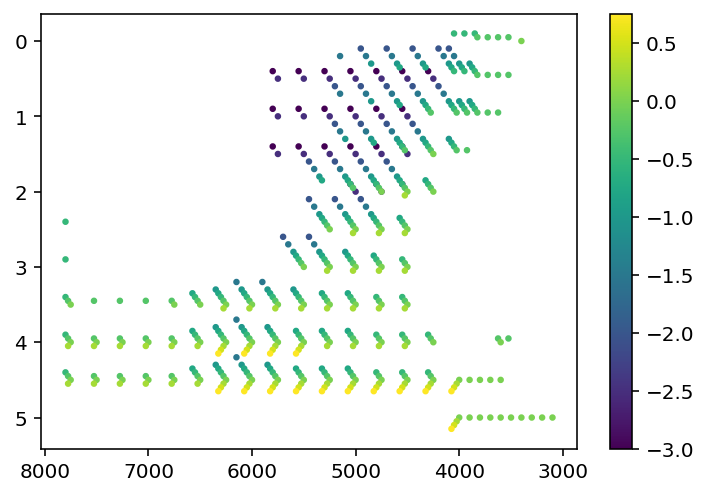

In [26]:
selection = trained_3x3x3

f, ax = plt.subplots()
s = ax.scatter(
    grids['teff_subgrid'][selection] + np.abs(100*grids['fe_h_subgrid'][selection]),
    grids['logg_subgrid'][selection] + 0.2*grids['fe_h_subgrid'][selection],
    c = grids['fe_h_subgrid'][selection], s = 5
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

In [27]:
s = 0
for g in priority['index_subgrid']:
    if g in trained_3x3x3:
        nr = priority['counts_dr4_init'][(priority['index_subgrid'] == g)][0]
        s += nr
        print(nr,s,"{:.1f}".format(100.*s/sum(priority['counts_dr4_init'])),"{:.1f}".format(100.*nr/sum(priority['counts_dr4_init'])))
    else:
        nr = priority['counts_dr4_init'][(priority['index_subgrid'] == g)][0]
        if nr > 500:
            print(nr)

30489 30489 3.6 3.6
25757 56246 6.7 3.1
23999 80245 9.5 2.9
22384 102629 12.2 2.7
21402 124031 14.7 2.5
21287 145318 17.3 2.5
20958 166276 19.8 2.5
19778 186054 22.1 2.3
18211 204265 24.3 2.2
16730 220995 26.3 2.0
15680 236675 28.1 1.9
14632 251307 29.9 1.7
14088 265395 31.5 1.7
13797 279192 33.2 1.6
12138 291330 34.6 1.4
11352 302682 36.0 1.3
10967 313649 37.3 1.3
9534 323183 38.4 1.1
9513 332696 39.5 1.1
9310 342006 40.6 1.1
9257 351263 41.7 1.1
8823 360086 42.8 1.0
8821 368907 43.8 1.0
8722 377629 44.9 1.0
8418 386047 45.9 1.0
8212 394259 46.8 1.0
7785 402044 47.8 0.9
7751 409795 48.7 0.9
7722 417517 49.6 0.9
7448 424965 50.5 0.9
7394 432359 51.4 0.9
7232 439591 52.2 0.9
6927 446518 53.1 0.8
6883 453401 53.9 0.8
6805 460206 54.7 0.8
6612 466818 55.5 0.8
6612 473430 56.2 0.8
6471 479901 57.0 0.8
6385 486286 57.8 0.8
6309 492595 58.5 0.7
6303 498898 59.3 0.7
5702 504600 60.0 0.7
5430 510030 60.6 0.6
5425 515455 61.2 0.6
5273 520728 61.9 0.6
5233 525961 62.5 0.6
4986 530947 63.1 0.6
49

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



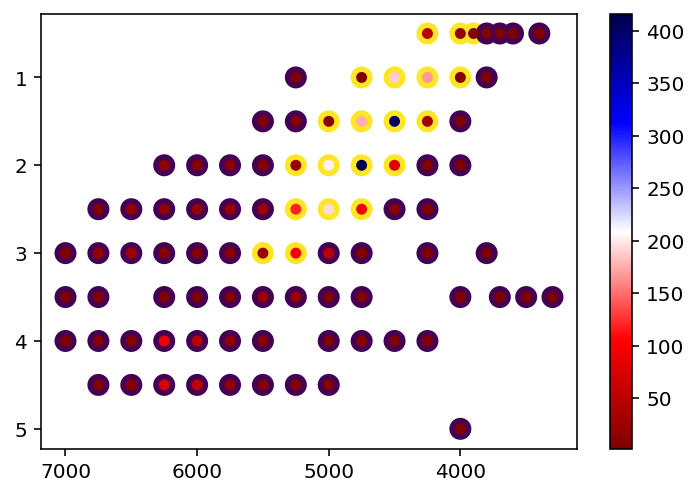

In [28]:
selection = (priority['fe_h_subgrid'] == -2.0) & (priority['counts_dr4_init'] > 1)

done = []
for s in priority['index_subgrid'][selection]:
    if s in trained_3x3x3:
        done.append(1)
    else:
        done.append(0)

f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = done,s=100,vmin=0,vmax=1
)
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],s=20,cmap='seismic_r'
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()